# Preparation

## Import Libraries

In [1]:
!apt-get update && apt-get install -y python3-opencv

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 https://developer.download.nvidia.com/compute/c

In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, average_precision_score
import seaborn as sns
import timm

In [2]:
timm.list_models('*')

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_x

In [3]:
timm.list_models('repvgg'+'*')

['repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4']

In [4]:
model_name = 'repvgg_b0'
model = timm.create_model(model_name, pretrained=False)
model
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-repvgg-weights/repvgg_b0-80ac3f1b.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': ('stem.conv_kxk.conv', 'stem.conv_1x1.conv'),
 'classifier': 'head.fc',
 'architecture': 'repvgg_b0'}

## Connect google drive & Change directory

In [5]:
# from google.colab import drive


# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/팀 프로젝트/COVID-19_detection_with_CT/')

## Set Arguments & hyperparameters

In [6]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [7]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 20
INPUT_SHAPE = 384
K_FOLDS = 5

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# check device
DEVICE

device(type='cuda')

## Data Augmetation

In [9]:
# Set Augmentation variable
VFLIP = True
HFLIP = True
ROTATE = True
FLIP_ROTATE = True
ANGLE = None

In [10]:
# ./data/augmentation 위치에 이미지를 생성하도록 만듦
# vflip : 상하로 뒤집을건지, hflip : 좌우로 뒤집을건지, rotate : 회전을 할건지 (한다면) angle : 지정한값으로 할건지(비우면 random)
def createimage(vflip=True, hflip=True, rotate=True, flip_rotate=True, angle=None):
    origin_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
    origin_df = origin_df[:578]

    # save original image
    for i in tqdm(range(578)):
        img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
        cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}.png', img)
        

    # vertical flip
    if vflip:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            vflip_img = cv2.flip(img, 0)
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_vflip.png', vflip_img)
            origin_df.loc[len(origin_df)] = [f'{i}_vflip.png', origin_df.iloc[i]['COVID']]

        
    # horizontal filp
    if hflip:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            hflip_img = cv2.flip(img, 1)
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_hflip.png', hflip_img)
            origin_df.loc[len(origin_df)] = [f'{i}_hflip.png', origin_df.iloc[i]['COVID']]

    # rotate
    if rotate:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            h, w = img.shape[:2]
            # rotate by Specific value
            if angle:
                rotation = cv2.getRotationMatrix2D((h/2, w/2), angle, 1)
                rotate_img = cv2.warpAffine(img, rotation, (h, w))
            # rotate by random value(5 ~ 35)
            else:
                rand_angle = np.random.randint(30)
                rotation = cv2.getRotationMatrix2D((h/2, w/2), 5+rand_angle, 1)
                rotate_img = cv2.warpAffine(img, rotation, (h, w))
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_rotate.png', rotate_img)
            origin_df.loc[len(origin_df)] = [f'{i}_rotate.png', origin_df.iloc[i]['COVID']]

    # flip-rotate
    if flip_rotate:
        for i in tqdm(range(578)):
            img = cv2.imread(f'./{DATA_DIR}/train/{i}.png')
            hflip_img = cv2.flip(img, 1)
            h, w = hflip_img.shape[:2]
            # rotate by Specific value
            if angle:
                rotation = cv2.getRotationMatrix2D((h/2, w/2), angle, 1)
                rotate_img = cv2.warpAffine(hflip_img, rotation, (h, w))
            # rotate by random value
            else:
                rand_angle = np.random.randint(30)
                rotation = cv2.getRotationMatrix2D((h/2, w/2), 5+rand_angle, 1)
                rotate_img = cv2.warpAffine(hflip_img, rotation, (h, w))
            cv2.imwrite(f'./{DATA_DIR}/augmentation/{i}_flip_rotate.png', rotate_img)
            origin_df.loc[len(origin_df)] = [f'{i}_flip_rotate.png', origin_df.iloc[i]['COVID']]

    print('\nsave csv file...')
    origin_df.to_csv(os.path.join(DATA_DIR, 'augmentation.csv'))
    print("ALL JOBS FINISHED")

    return origin_df

In [11]:
new_df = createimage(VFLIP, HFLIP, ROTATE, FLIP_ROTATE, ANGLE)

100% 578/578 [00:05<00:00, 104.30it/s]
100% 578/578 [00:06<00:00, 93.25it/s]
100% 578/578 [00:06<00:00, 93.46it/s]
100% 578/578 [00:07<00:00, 81.97it/s]
100% 578/578 [00:07<00:00, 81.03it/s]


save csv file...
ALL JOBS FINISHED


## wandb

In [12]:
# wandb
import wandb
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb.init(project="test-project", entity="team6", name = model_name + "_" + '0') 

wandb_kwargs = {"project": "optuna_test",}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="acc")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: spiritkgh (use `wandb login --relogin` to force relogin)


/tmp/ipykernel_45167/4233595460.py:8: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="acc")


# Define Dataloader

## Train & Validation Set loader

In [13]:
class ValidationDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        self.db = self.db[578:]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            print(os.path.join(self.data_dir,'train',data['file_name']))
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID'], data['file_name']

In [14]:
class CustomDataset(Dataset):
    ####################################################################
    ####          인자값에 mode 삭제 후 idx를 추가해줘야함          ####
    ####################################################################
    def __init__(self, data_dir, idx, input_shape):
        self.data_dir = data_dir
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.idx = idx
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.db = self.db.iloc[self.idx]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################        
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        ####################################################################
        ####          읽어올 label 정보 csv를 train에서 바꿔줌          ####
        ####################################################################
        db = pd.read_csv(os.path.join(self.data_dir, 'augmentation.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        ####################################################################
        ####           이미지를 읽어올 경로를 train에서 바꿔줌          ####
        ####################################################################
        cvimg = cv2.imread(os.path.join(self.data_dir,'augmentation',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        ####################################################################
        ####           리턴값에 data['file_name'] 추가해줘야함          ####
        ####################################################################
        return trans_image, data['COVID'], data['file_name']

# Define Model

In [15]:
   
import timm
import torch.nn.functional as F

class Model_Define(nn.Module):
    def __init__(self, num_classes):
        super(Model_Define, self).__init__()
        self.model = timm.create_model(model_name, pretrained=False, in_chans=3)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(in_features=1000, out_features=num_classes)
        
    def forward(self, x):
        x = self.model(x)
        x = F.relu(self.fc(x))
        output = self.softmax(x)
        return output
    

## Utils
### EarlyStopper

In [16]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"
            wandb.log({'Early stopping counter': self.patience_counter})

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, (model_name + "_aug_best.pt"))
            
        print(msg)

### Trainer

In [17]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'\nEpoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        wandb.log({'train_accuracy': self.train_score, 'train_loss': self.train_mean_loss})
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'\nEpoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        wandb.log({'valid_accuracy': self.validation_score, 'valid_loss': self.val_mean_loss})
        print(msg)

### Metrics

In [18]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load model and other utils

In [19]:
# Set optimizer, scheduler, loss function, metric function
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn

### K-Fold 학습 진행

In [20]:
# from sklearn.model_selection import KFold


# kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [21]:
# train_loss_list = [[] for _ in range(EPOCHS)]
# val_loss_list = [[] for _ in range(EPOCHS)]

# for fold, (train_idx, val_idx) in enumerate(kfold.split(range(578))):
#     print(f'============================{fold+1}th fold============================')
#     augmentations = 0
#     length = len(train_idx)
#     if VFLIP:
#         augmentations += 1
#         vflip_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, vflip_idx))
#     if HFLIP:
#         augmentations += 1
#         hflip_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, hflip_idx))
#     if ROTATE:
#         augmentations += 1
#         rotate_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, rotate_idx))
#     if FLIP_ROTATE:
#         augmentations += 1
#         frotate_idx = train_idx[:length] + (578 * augmentations)
#         train_idx = np.concatenate((train_idx, frotate_idx))

#     train_dataset = CustomDataset(data_dir=DATA_DIR, idx=train_idx, input_shape=INPUT_SHAPE)
#     validation_dataset = CustomDataset(data_dir=DATA_DIR, idx=val_idx, input_shape=INPUT_SHAPE)
#     train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

#     model = Model_Define(NUM_CLS).to(DEVICE)

#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))

#     # Set trainer
#     trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

#     for epoch_index in tqdm(range(EPOCHS)):
#         trainer.train_epoch(train_dataloader, epoch_index)
#         trainer.validate_epoch(validation_dataloader, epoch_index)

#         train_loss = trainer.train_mean_loss
#         val_loss = trainer.val_mean_loss
        
#         train_loss_list[epoch_index].append(train_loss)
#         val_loss_list[epoch_index].append(val_loss)
        
#         del train_loss, val_loss


In [22]:
# import matplotlib.pyplot as plt


# fig, loss_ax = plt.subplots()

# mean_train_loss = [np.mean(train_loss_list[i]) for i in range(EPOCHS)]
# mean_val_loss = [np.mean(val_loss_list[i]) for i in range(EPOCHS)]

# loss_ax.plot(mean_train_loss, 'y', label='train loss')
# loss_ax.plot(mean_val_loss, 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='lower left')

# images = wandb.Image(loss_ax)
# wandb.log({"examples": images}

# plt.show()

In [23]:
# np.argmin(mean_val_loss)

## prev train

In [24]:
train_dataset = CustomDataset(data_dir=DATA_DIR, idx=range(len(new_df)), input_shape=INPUT_SHAPE)
validation_dataset = ValidationDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

Loading dataset..
Loading dataset..


In [25]:
model = Model_Define(NUM_CLS).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [26]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(model.state_dict(), model_name + "_augonly_best.pt")

  0% 0/30 [00:00<?, ?it/s]


Epoch 0, Train loss: 0.6896731515725454, Acc: 0.5529411764705883, F1-Macro: 0.5517656487314344


  3% 1/30 [04:25<2:08:06, 265.06s/it]


Epoch 0, Val loss: 0.989865243434906, Acc: 0.5882352941176471, F1-Macro: 0.5572093023255814

Epoch 1, Train loss: 0.5555949694580502, Acc: 0.729757785467128, F1-Macro: 0.7259875013035408


  7% 2/30 [08:42<2:02:38, 262.82s/it]


Epoch 1, Val loss: 1.0786292552947998, Acc: 0.75, F1-Macro: 0.7473224043715847
Early stopping counter 1/10

Epoch 2, Train loss: 0.45901843044492935, Acc: 0.7875432525951557, F1-Macro: 0.7868568746183278


 10% 3/30 [13:07<1:58:33, 263.47s/it]


Epoch 2, Val loss: 1.0690634101629257, Acc: 0.7205882352941176, F1-Macro: 0.7099887766554434
Early stopping counter 2/10

Epoch 3, Train loss: 0.4052220068044133, Acc: 0.8262975778546713, F1-Macro: 0.8257768337156977


 13% 4/30 [17:46<1:56:12, 268.19s/it]


Epoch 3, Val loss: 1.5336550772190094, Acc: 0.6764705882352942, F1-Macro: 0.6739319965126417
Early stopping counter 3/10

Epoch 4, Train loss: 0.3373203746146626, Acc: 0.8557093425605536, F1-Macro: 0.8550629470089122


 17% 5/30 [22:27<1:53:16, 271.86s/it]


Epoch 4, Val loss: 1.6951068341732025, Acc: 0.5882352941176471, F1-Macro: 0.5177304964539007
Early stopping counter 4/10

Epoch 5, Train loss: 0.2637250680062506, Acc: 0.8979238754325259, F1-Macro: 0.8974854320612373

Epoch 5, Val loss: 0.6825398802757263, Acc: 0.7205882352941176, F1-Macro: 0.7205277958035907


 20% 6/30 [27:11<1:50:15, 275.63s/it]

Validation loss decreased 0.989865243434906 -> 0.6825398802757263

Epoch 6, Train loss: 0.1981709314717187, Acc: 0.9200692041522491, F1-Macro: 0.9196728726197949

Epoch 6, Val loss: 1.0350127760320902, Acc: 0.6470588235294118, F1-Macro: 0.6458333333333334
Early stopping counter 1/10


 23% 7/30 [31:50<1:46:00, 276.56s/it]


Epoch 7, Train loss: 0.1769585107349687, Acc: 0.9290657439446367, F1-Macro: 0.9287545521265463

Epoch 7, Val loss: 1.319972813129425, Acc: 0.7352941176470589, F1-Macro: 0.734375
Early stopping counter 2/10


 27% 8/30 [36:23<1:40:58, 275.38s/it]


Epoch 8, Train loss: 0.12549809211244187, Acc: 0.9501730103806229, F1-Macro: 0.9499380240051121

Epoch 8, Val loss: 1.7221490144729614, Acc: 0.6323529411764706, F1-Macro: 0.6135485337576722
Early stopping counter 3/10


 30% 9/30 [40:50<1:35:30, 272.86s/it]


Epoch 9, Train loss: 0.08978014830499888, Acc: 0.9681660899653979, F1-Macro: 0.9680128968612023

Epoch 9, Val loss: 1.8920087814331055, Acc: 0.6470588235294118, F1-Macro: 0.6392572944297081
Early stopping counter 4/10


 33% 10/30 [45:32<1:31:52, 275.60s/it]


Epoch 10, Train loss: 0.05540951054232816, Acc: 0.9809688581314879, F1-Macro: 0.9808853676437076

Epoch 10, Val loss: 3.0334337949752808, Acc: 0.6764705882352942, F1-Macro: 0.6575091575091576
Early stopping counter 5/10


 37% 11/30 [50:15<1:28:00, 277.91s/it]


Epoch 11, Train loss: 0.04226928487834003, Acc: 0.9865051903114187, F1-Macro: 0.9864472266114857

Epoch 11, Val loss: 1.5943462252616882, Acc: 0.6470588235294118, F1-Macro: 0.6442894507410637
Early stopping counter 6/10


 40% 12/30 [55:06<1:24:34, 281.94s/it]


Epoch 12, Train loss: 0.032322794716391295, Acc: 0.9896193771626297, F1-Macro: 0.9895752622777438

Epoch 12, Val loss: 2.2241568118333817, Acc: 0.6470588235294118, F1-Macro: 0.6442894507410637
Early stopping counter 7/10


 43% 13/30 [59:55<1:20:25, 283.87s/it]


Epoch 13, Train loss: 0.08117540177320026, Acc: 0.9733564013840831, F1-Macro: 0.9732419602329332

Epoch 13, Val loss: 3.3792872428894043, Acc: 0.75, F1-Macro: 0.7432822562735955
Early stopping counter 8/10


 47% 14/30 [1:05:02<1:17:34, 290.89s/it]


Epoch 14, Train loss: 0.05000673280770166, Acc: 0.9830449826989619, F1-Macro: 0.9829625687840717

Epoch 14, Val loss: 1.4790935963392258, Acc: 0.6911764705882353, F1-Macro: 0.6905742145178765
Early stopping counter 9/10


 50% 15/30 [1:10:27<1:15:17, 301.17s/it]


Epoch 15, Train loss: 0.022563293038789803, Acc: 0.995847750865052, F1-Macro: 0.9958297258297258


 50% 15/30 [1:15:09<1:15:09, 300.66s/it]


Epoch 15, Val loss: 1.254356749355793, Acc: 0.75, F1-Macro: 0.7486410089149815
Early stopping counter 10/10
Early stopped


In [36]:
# torch.save(model.state_dict(), model_name + "_aug1_best.pt")

## Inference
### 모델 로드

In [27]:
TRAINED_MODEL_PATH = model_name + "_augonly_best.pt"

## confusion matrix

In [28]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    PR_AUC = average_precision_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [29]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH))

train_actual = []
validation_actual = []
train_pred_lst = []
validation_pred_lst = []

model.eval()
with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(train_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        train_actual += (list(label.numpy()))
        train_pred_lst.extend(pred.argmax(dim=1).tolist())

with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(validation_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        validation_actual += (list(label))
        validation_pred_lst.extend(pred.argmax(dim=1).tolist())

91it [03:26,  2.27s/it]
3it [00:04,  1.59s/it]



정확도: 0.9955
정밀도: 0.9905
재현율: 1.0000
AUC: 0.9958
F1: 0.9955


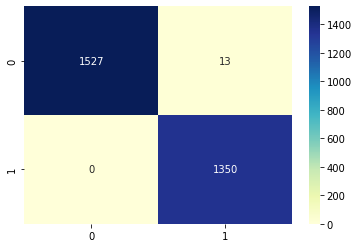

In [30]:
get_clf_eval(train_actual, train_pred_lst)


정확도: 0.6912
정밀도: 0.7097
재현율: 0.6471
AUC: 0.6912
F1: 0.6906


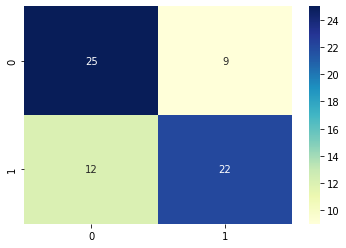

In [31]:
get_clf_eval(validation_actual, validation_pred_lst)

# Make submission

### Load dataset

In [32]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))


        ####################################################################
        ####                 리턴값에 -1 추가해줘야함                   ####
        ####################################################################
        return trans_image, -1, data['file_name']

In [33]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


## 추론 진행

In [34]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH))

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, _, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:02,  2.36s/it]

tensor([[9.9965e-01, 3.5013e-04],
        [9.9509e-01, 4.9082e-03],
        [4.6210e-01, 5.3790e-01],
        [2.9001e-04, 9.9971e-01],
        [9.9999e-01, 9.0411e-06],
        [2.3072e-05, 9.9998e-01],
        [3.0640e-03, 9.9694e-01],
        [8.2883e-01, 1.7117e-01],
        [1.7055e-01, 8.2945e-01],
        [6.8502e-06, 9.9999e-01],
        [9.9993e-01, 7.4870e-05],
        [1.3326e-01, 8.6674e-01],
        [9.9986e-01, 1.4491e-04],
        [6.1083e-01, 3.8917e-01],
        [1.6219e-01, 8.3781e-01],
        [9.8463e-01, 1.5369e-02],
        [9.9798e-01, 2.0240e-03],
        [9.9999e-01, 1.1369e-05],
        [9.9984e-01, 1.6092e-04],
        [9.9995e-01, 5.4868e-05],
        [1.0000e+00, 3.6161e-06],
        [9.9969e-01, 3.0786e-04],
        [8.7175e-03, 9.9128e-01],
        [1.0000e+00, 4.8091e-09],
        [1.0865e-05, 9.9999e-01],
        [9.9950e-01, 5.0151e-04],
        [9.9890e-01, 1.0976e-03],
        [3.9415e-02, 9.6059e-01],
        [2.9713e-03, 9.9703e-01],
        [2.030

2it [00:04,  2.23s/it]

tensor([[1.0442e-09, 1.0000e+00],
        [9.9954e-01, 4.6486e-04],
        [9.9757e-01, 2.4298e-03],
        [8.7708e-01, 1.2292e-01],
        [1.7886e-03, 9.9821e-01],
        [2.4678e-01, 7.5322e-01],
        [4.9083e-03, 9.9509e-01],
        [9.9990e-01, 1.0139e-04],
        [2.3111e-04, 9.9977e-01],
        [8.7918e-01, 1.2082e-01],
        [9.6684e-01, 3.3161e-02],
        [2.5100e-03, 9.9749e-01],
        [2.1325e-01, 7.8675e-01],
        [6.9984e-03, 9.9300e-01],
        [4.0990e-01, 5.9010e-01],
        [6.1953e-01, 3.8047e-01],
        [3.6479e-04, 9.9964e-01],
        [9.2042e-01, 7.9576e-02],
        [1.4834e-01, 8.5166e-01],
        [2.3167e-06, 1.0000e+00],
        [9.5004e-01, 4.9956e-02],
        [9.2448e-01, 7.5518e-02],
        [2.6857e-03, 9.9731e-01],
        [6.4977e-04, 9.9935e-01],
        [6.6310e-01, 3.3690e-01],
        [3.2697e-04, 9.9967e-01],
        [3.4498e-02, 9.6550e-01],
        [2.5476e-03, 9.9745e-01],
        [2.5643e-04, 9.9974e-01],
        [8.550

4it [00:06,  1.70s/it]

tensor([[1.4505e-04, 9.9985e-01],
        [3.8749e-08, 1.0000e+00],
        [1.3277e-08, 1.0000e+00],
        [1.0309e-03, 9.9897e-01],
        [9.0583e-01, 9.4172e-02],
        [1.0000e+00, 1.0968e-06],
        [9.9573e-01, 4.2701e-03],
        [9.9999e-01, 6.5752e-06],
        [9.9887e-01, 1.1286e-03],
        [9.7900e-01, 2.0998e-02],
        [3.4460e-04, 9.9966e-01],
        [4.4230e-01, 5.5770e-01],
        [1.0000e+00, 3.8095e-06],
        [1.0000e+00, 1.8234e-07],
        [1.6261e-04, 9.9984e-01],
        [2.8854e-07, 1.0000e+00],
        [2.7098e-05, 9.9997e-01],
        [8.5569e-01, 1.4431e-01],
        [9.9993e-01, 7.0485e-05],
        [2.9191e-02, 9.7081e-01],
        [9.6787e-01, 3.2128e-02],
        [9.9809e-06, 9.9999e-01],
        [1.0000e+00, 4.4926e-06],
        [4.1647e-06, 1.0000e+00],
        [9.9954e-01, 4.6226e-04],
        [2.9627e-04, 9.9970e-01],
        [9.3745e-05, 9.9991e-01],
        [9.9941e-01, 5.9391e-04],
        [5.3711e-06, 9.9999e-01],
        [1.395

In [35]:
# test set에 대한 gradcam
grad_cam(test_dataset, 'test')

NameError: name 'grad_cam' is not defined

## 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv(model_name + '_aug1_prediction.csv', index=False)


dfp = pd.DataFrame({'file_name':file_lst, 'COVID':prob_lst})
# df.sort_values(by=['file_name'], inplace=True)
dfp.to_csv(model_name + '_aug1_pred.csv', index=False)

In [ ]:
wandb.finish()